# Marker-Free PSM Segmentation (Channel 1 + Channel 2) - IMPROVED VERSION

## Overview

This notebook implements **marker-free PSM segmentation** using only Channel 1 (nuclei) and Channel 2 (membranes), without requiring the PSM-specific Channel 3 marker. This is critical for experiments where Channel 3 is unavailable.

## What This Notebook Does

1. **Learns PSM statistics** from existing Channel 3 masks (size, location)
2. **Extracts 13 features** per pixel from CH1 and CH2
3. **Trains an improved Random Forest** with nearby-tissue negative sampling
4. **Predicts PSM** with size and location filtering
5. **Evaluates** against Channel 3 proxy masks (Dice, IoU)

## Key Innovations (vs Basic Version)

| Innovation | Description | Impact |
|------------|-------------|--------|
| Position Features | Normalized (y,x) coordinates [0-1] | 29% of model importance |
| Nearby-Tissue Negatives | Sample negatives within 15px of PSM boundary | Forces fine PSM-vs-tissue distinctions |
| CH1/CH2 Ratio | Nuclear density vs membrane density | Captures tissue characteristics |
| Size/Location Filtering | Reject predictions outside learned PSM statistics | Reduces false positives |

## Features Used (13 total)

- **CH1 (5)**: Raw intensity, Gaussian sigma=1.5/3.5/8.0, Sobel edges
- **CH2 (5)**: Raw intensity, Gaussian sigma=1.5/3.5/8.0, Sobel edges
- **Ratio (1)**: CH1 / (CH2 + epsilon), smoothed
- **Position (2)**: Normalized y and x coordinates

## Key Parameters (Configurable)

| Parameter | Default | Description |
|-----------|---------|-------------|
| `NEARBY_DILATION_RADIUS` | 15 | How far from PSM to sample negative pixels |
| `n_estimators` | 150 | Number of Random Forest trees |
| `max_depth` | 18 | Maximum tree depth |
| `SCALE_FACTOR` | 0.25 | XY downsampling factor |

## How to Use

1. **Ensure CH3 masks exist**: This notebook uses `mask_santi/` masks as training ground truth
2. **Set data paths**: Modify `RAW_DIR` and `GT_MASK_DIR` if needed
3. **Run all cells**: Model will train and predict on test frames
4. **Evaluate results**: Check Dice scores and visualizations

## Expected Results

- Mean Dice: ~0.70 (against CH3 proxy masks)
- Best Dice: up to 0.83 on well-positioned frames
- Processing time: ~150s per frame

## Output

- Masks: `psm_from_ch1_ch2_improved/mask_tXXXX_improved.tif`
- Model: `psm_from_ch1_ch2_improved/rf_model_improved.joblib`
- Statistics: `psm_from_ch1_ch2_improved/psm_statistics.joblib`


In [1]:
# Clear progress to rerun
import json
from pathlib import Path
progress_file = Path("psm_from_ch1_ch2_improved/progress.json")
if progress_file.exists():
    progress_file.write_text('{"processed": []}')
    print("Progress cleared - will reprocess all frames")

Progress cleared - will reprocess all frames


In [2]:
# %% CELL 1: SETUP
import os
import json
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tifffile import imread, imwrite

from scipy import ndimage as ndi
from scipy.ndimage import gaussian_filter, center_of_mass

from skimage import filters, morphology, measure, transform

from sklearn.ensemble import RandomForestClassifier
import joblib

np.random.seed(42)
print("Imports loaded.")


Imports loaded.


In [ ]:
# =============================================================================
# CELL 2: CONFIGURATION - MODIFY THESE FOR YOUR DATA
# =============================================================================

# -----------------------------------------------------------------------------
# INPUT PATHS - CHANGE THESE TO POINT TO YOUR DATA
# -----------------------------------------------------------------------------
# RAW_DIR: Directory containing your raw TIFF files
# Expected naming: tXXXX_Channel 1.tif, tXXXX_Channel 2.tif
RAW_DIR = Path(".")

# GT_MASK_DIR: Directory containing Channel 3 PSM masks (used as training labels)
# These masks are generated by PSM_Segmentation.ipynb from Channel 3
# Expected naming: mask_tXXXX_Channel 3.tif
GT_MASK_DIR = Path("mask_santi")

# -----------------------------------------------------------------------------
# OUTPUT PATHS - WHERE RESULTS WILL BE SAVED
# -----------------------------------------------------------------------------
OUTPUT_DIR = Path("psm_from_ch1_ch2_improved")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = OUTPUT_DIR / "rf_model_improved.joblib"      # Trained model (reusable)
STATS_PATH = OUTPUT_DIR / "psm_statistics.joblib"         # PSM size/location stats
FEATURE_STATS_PATH = OUTPUT_DIR / "feature_stats.joblib"  # Feature importance analysis
PROGRESS_PATH = OUTPUT_DIR / "progress.json"              # Checkpoint for resuming
RESULTS_PATH = OUTPUT_DIR / "results.csv"                 # Per-frame Dice/IoU scores
VIZ_DIR = OUTPUT_DIR / "visualizations"
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# -----------------------------------------------------------------------------
# TRAINING CONFIGURATION - MODIFY TO RETRAIN WITH DIFFERENT DATA
# -----------------------------------------------------------------------------
# TRAINING_FRAMES: List of timepoints to use for training
# Must have corresponding masks in GT_MASK_DIR
# Tip: Include frames from different developmental stages for better generalization
TRAINING_FRAMES = [1, 30, 70, 120, 140, 180, 200]

# TEST_MODE: Set to False to process ALL frames (not just TEST_FRAMES)
TEST_MODE = True

# TEST_FRAMES: Frames to evaluate when TEST_MODE=True
# These should NOT overlap with TRAINING_FRAMES for fair evaluation
TEST_FRAMES = [100, 110, 180, 190, 200]

# -----------------------------------------------------------------------------
# PROCESSING PARAMETERS - TUNE THESE FOR SPEED/QUALITY TRADEOFF
# -----------------------------------------------------------------------------
# SCALE_FACTOR: Downsampling factor for speed (0.25 = 4x smaller)
# Lower = faster but less precise; Higher = slower but more accurate
SCALE_FACTOR = 0.25

# SLICE_OFFSET: How many Z-slices around center to sample for training
SLICE_OFFSET = 8

# -----------------------------------------------------------------------------
# KEY INNOVATION PARAMETERS - THESE MAKE THE IMPROVED VERSION WORK
# -----------------------------------------------------------------------------
# NEARBY_DILATION_RADIUS: Distance (pixels) from PSM boundary to sample negatives
# This forces the model to learn fine PSM-vs-adjacent-tissue distinctions
# Higher = more diverse negatives; Lower = harder distinctions
NEARBY_DILATION_RADIUS = 15

# Safety margins for sampling
SAFE_EROSION_RADIUS = 2   # Erode PSM to get confident positive pixels
SAFE_DILATION_RADIUS = 3  # Buffer between positives and negatives

# -----------------------------------------------------------------------------
# POST-PROCESSING PARAMETERS
# -----------------------------------------------------------------------------
CLOSING_RADIUS_3D = 6     # 3D morphological closing to fill holes
SMOOTH_SIGMA = 1.5        # Gaussian smoothing for clean boundaries
EVAL_Z_SLICE = 188        # Z-slice where expert GT exists (for evaluation)

print("=" * 60)
print("CONFIGURATION LOADED - IMPROVED VERSION")
print("=" * 60)
print(f"  Input data:        {RAW_DIR}")
print(f"  Training masks:    {GT_MASK_DIR}")
print(f"  Training frames:   {TRAINING_FRAMES}")
print(f"  Test frames:       {TEST_FRAMES}")
print(f"  Negative sampling: {NEARBY_DILATION_RADIUS}px from PSM boundary")


Configuration loaded - IMPROVED VERSION
  NEARBY_DILATION_RADIUS: 15


In [ ]:
# =============================================================================
# CELL 3: LEARN PSM STATISTICS FROM CHANNEL 3 MASKS
# =============================================================================
# This cell analyzes existing CH3 masks to learn:
#   - Typical PSM size (area in pixels)
#   - Typical PSM location (centroid position)
#
# These statistics are used later to FILTER predictions:
#   - Reject regions that are too small or too large
#   - Reject regions in unexpected locations (e.g., head instead of tail)
#
# WHY THIS HELPS: Without CH3, the model might detect tissue everywhere.
# By learning WHERE and HOW BIG PSM typically is, we can filter out
# false positives that don't match expected PSM characteristics.
# =============================================================================

def compute_psm_statistics(training_frames):
    """Compute statistics about PSM size and location from CH3 masks."""
    sizes = []
    centroids_y = []
    centroids_x = []
    
    for t in training_frames:
        gt_path = GT_MASK_DIR / f"mask_t{t:04d}_Channel 3.tif"
        if not gt_path.exists():
            continue
        
        mask = imread(str(gt_path)) > 0
        
        # Get middle slice for 2D statistics
        z = mask.shape[0] // 2
        msk_2d = mask[z]
        
        if msk_2d.sum() > 0:
            sizes.append(msk_2d.sum())
            cy, cx = center_of_mass(msk_2d)
            centroids_y.append(cy / msk_2d.shape[0])  # Normalized 0-1
            centroids_x.append(cx / msk_2d.shape[1])
    
    if not sizes:
        return None
    
    stats = {
        'size_min': np.percentile(sizes, 5),
        'size_max': np.percentile(sizes, 95) * 2,  # Allow some margin
        'size_mean': np.mean(sizes),
        'centroid_y_mean': np.mean(centroids_y),
        'centroid_y_std': np.std(centroids_y) + 0.1,  # Add margin
        'centroid_x_mean': np.mean(centroids_x),
        'centroid_x_std': np.std(centroids_x) + 0.1,
    }
    
    print("PSM Statistics from CH3 masks:")
    for k, v in stats.items():
        print(f"  {k}: {v:.2f}")
    
    return stats


In [ ]:
# =============================================================================
# CELL 4: IMPROVED FEATURE ENGINEERING
# =============================================================================
# This is the CORE of the improved method. We extract 13 features per pixel:
#
# FROM CHANNEL 1 (Nuclei - H2B-Cerulean) - 5 features:
#   1. Raw intensity
#   2. Gaussian blur sigma=1.5 (fine texture)
#   3. Gaussian blur sigma=3.5 (medium texture)
#   4. Gaussian blur sigma=8.0 (coarse context)
#   5. Sobel edges (boundaries)
#
# FROM CHANNEL 2 (Membranes - Utrophin) - 5 features:
#   6-10. Same as above
#
# RATIO FEATURE - 1 feature:
#   11. CH1/CH2 ratio (nuclear vs membrane density)
#       PSM cells may have distinctive nuclear/membrane patterns
#
# POSITION FEATURES - 2 features (KEY INNOVATION):
#   12. Normalized Y coordinate [0-1]
#   13. Normalized X coordinate [0-1]
#       PSM is ALWAYS in the posterior tail region, not head or sides
#       These features teach the model WHERE to look
#
# WHY MULTI-SCALE? Different sigmas capture different information:
#   - Small sigma (1.5): cellular-level texture
#   - Medium sigma (3.5): tissue-level patterns
#   - Large sigma (8.0): regional context
# =============================================================================

def get_improved_features(ch1_2d: np.ndarray, ch2_2d: np.ndarray):
    """Extract 13 improved features including ratio and position."""
    ch1 = ch1_2d.astype(np.float32)
    ch2 = ch2_2d.astype(np.float32)
    
    h, w = ch1.shape
    
    feats = []
    names = []
    
    # CH1 features (5)
    feats.append(ch1.flatten())
    names.append("CH1 Intensity")
    
    feats.append(filters.gaussian(ch1, sigma=1.5).flatten())
    names.append("CH1 Texture (1.5)")
    
    feats.append(filters.gaussian(ch1, sigma=3.5).flatten())
    names.append("CH1 Shape (3.5)")
    
    feats.append(filters.gaussian(ch1, sigma=8.0).flatten())
    names.append("CH1 Context (8.0)")
    
    feats.append(filters.sobel(ch1).flatten())
    names.append("CH1 Edges")
    
    # CH2 features (5)
    feats.append(ch2.flatten())
    names.append("CH2 Intensity")
    
    feats.append(filters.gaussian(ch2, sigma=1.5).flatten())
    names.append("CH2 Texture (1.5)")
    
    feats.append(filters.gaussian(ch2, sigma=3.5).flatten())
    names.append("CH2 Shape (3.5)")
    
    feats.append(filters.gaussian(ch2, sigma=8.0).flatten())
    names.append("CH2 Context (8.0)")
    
    feats.append(filters.sobel(ch2).flatten())
    names.append("CH2 Edges")
    
    # Ratio feature: CH1 / (CH2 + epsilon)
    ratio = ch1 / (ch2 + 1e-6)
    ratio = np.clip(ratio, 0, 10)  # Clip extreme values
    feats.append(filters.gaussian(ratio, sigma=2.0).flatten())
    names.append("CH1/CH2 Ratio")
    
    # Position features (normalized 0-1)
    yy, xx = np.mgrid[0:h, 0:w]
    feats.append((yy / h).flatten())
    names.append("Position Y")
    
    feats.append((xx / w).flatten())
    names.append("Position X")
    
    X = np.vstack(feats).T
    return X, names


In [ ]:
# =============================================================================
# CELL 5: IMPROVED TRAINING DATA GENERATION
# =============================================================================
# This cell generates balanced training data with a KEY INNOVATION:
#
# PROBLEM WITH BASIC APPROACH:
#   - Sample positives from PSM, negatives from anywhere else
#   - Model learns "bright tissue vs dark background" (easy)
#   - Result: Over-segments ALL tissue, not just PSM
#
# OUR SOLUTION - NEARBY-TISSUE NEGATIVE SAMPLING:
#   - Sample positives from inside PSM (eroded for safety)
#   - Sample negatives ONLY from tissue ADJACENT to PSM (within 15px)
#   - Model must learn "PSM tissue vs nearby non-PSM tissue" (hard)
#   - Result: Learns actual PSM-specific patterns
#
# This is why the improved version achieves Dice 0.70 vs 0.49 for basic.
#
# TRAINING PROCESS:
#   1. Load CH1, CH2, and CH3 mask for each training frame
#   2. Downsample for speed
#   3. Create safe_psm (eroded mask) for positive samples
#   4. Create nearby_tissue (dilated - original) for negative samples
#   5. Extract features and balance classes 1:1
# =============================================================================

def raw_file(t: int, channel: int) -> Path:
    return RAW_DIR / f"t{t:04d}_Channel {channel}.tif"

def gt_mask_file(t: int) -> Path:
    return GT_MASK_DIR / f"mask_t{t:04d}_Channel 3.tif"

def load_raw_volume(t: int, channel: int) -> np.ndarray:
    p = raw_file(t, channel)
    if not p.exists():
        raise FileNotFoundError(f"Missing: {p}")
    return imread(str(p))

def load_gt_mask_volume(t: int) -> np.ndarray:
    p = gt_mask_file(t)
    if not p.exists():
        raise FileNotFoundError(f"Missing: {p}")
    return imread(str(p)) > 0

def dice_score(pred, gt):
    pred, gt = pred.astype(bool), gt.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    denom = pred.sum() + gt.sum()
    return 1.0 if denom == 0 else (2.0 * inter / denom)

def iou_score(pred, gt):
    pred, gt = pred.astype(bool), gt.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return 1.0 if union == 0 else (inter / union)


def generate_improved_training_data(ch1_vol, ch2_vol, gt_vol, scale):
    """Generate training data with nearby-tissue negatives only."""
    
    # Downsample
    small_ch1 = transform.rescale(ch1_vol.astype(np.float32), scale,
                                   preserve_range=True, anti_aliasing=True).astype(np.float32)
    small_ch2 = transform.rescale(ch2_vol.astype(np.float32), scale,
                                   preserve_range=True, anti_aliasing=True).astype(np.float32)
    small_gt = transform.resize(gt_vol.astype(np.float32), small_ch1.shape,
                                 order=0, preserve_range=True, anti_aliasing=False) > 0.5
    
    zc = small_ch1.shape[0] // 2
    z_slices = [zc, zc - SLICE_OFFSET, zc + SLICE_OFFSET]
    
    X_list, y_list = [], []
    
    for z in z_slices:
        if z < 0 or z >= small_ch1.shape[0]:
            continue
        
        img1 = small_ch1[z]
        img2 = small_ch2[z]
        msk = small_gt[z]
        
        msz = int(msk.sum())
        if msz < 50 or msz > 25000:
            continue
        
        # Safe PSM region (eroded)
        safe_psm = morphology.binary_erosion(msk, morphology.disk(SAFE_EROSION_RADIUS))
        
        # Nearby tissue region (dilated PSM minus PSM itself)
        dilated = morphology.binary_dilation(msk, morphology.disk(NEARBY_DILATION_RADIUS))
        nearby_tissue = dilated & ~morphology.binary_dilation(msk, morphology.disk(SAFE_DILATION_RADIUS))
        
        # Also need some actual tissue in nearby region (not just black background)
        tissue_mask = img1 > np.percentile(img1, 20)  # Rough tissue detection
        nearby_tissue = nearby_tissue & tissue_mask
        
        X, _ = get_improved_features(img1, img2)
        
        # Labels: 1=PSM, 2=nearby tissue
        labels = np.zeros(img1.shape, dtype=np.uint8)
        labels[safe_psm] = 1
        labels[nearby_tissue] = 2
        
        y = labels.flatten()
        
        idx_pos = np.where(y == 1)[0]
        idx_neg = np.where(y == 2)[0]
        
        n = min(len(idx_pos), len(idx_neg))
        if n < 100:
            continue
        
        # Balance 1:1
        idx_pos = np.random.choice(idx_pos, size=n, replace=False)
        idx_neg = np.random.choice(idx_neg, size=n, replace=False)
        idx = np.concatenate([idx_pos, idx_neg])
        
        X_list.append(X[idx])
        y_list.append(y[idx])
    
    if not X_list:
        return None, None
    
    return np.vstack(X_list), np.concatenate(y_list)


def train_improved_model(training_frames):
    """Train improved RF model."""
    X_all, y_all = [], []
    
    for t in training_frames:
        print(f"Loading t={t:04d}...")
        ch1 = load_raw_volume(t, 1)
        ch2 = load_raw_volume(t, 2)
        gt = load_gt_mask_volume(t)
        
        X, y = generate_improved_training_data(ch1, ch2, gt, SCALE_FACTOR)
        if X is not None:
            X_all.append(X)
            y_all.append(y)
            print(f"  Added {len(y):,} pixels (nearby-tissue negatives)")
        
        del ch1, ch2, gt
    
    if not X_all:
        raise RuntimeError("No training data")
    
    X_train = np.vstack(X_all)
    y_train = np.concatenate(y_all)
    
    print(f"\nTraining RF on {len(y_train):,} pixels with 13 features...")
    
    clf = RandomForestClassifier(
        n_estimators=150,
        max_depth=18,
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=42,
        class_weight='balanced',
    )
    clf.fit(X_train, y_train)
    
    _, feat_names = get_improved_features(
        np.zeros((10, 10), dtype=np.float32),
        np.zeros((10, 10), dtype=np.float32)
    )
    feature_stats = (feat_names, clf.feature_importances_)
    
    joblib.dump(clf, MODEL_PATH)
    joblib.dump(feature_stats, FEATURE_STATS_PATH)
    
    print(f"Saved: {MODEL_PATH}")
    return clf, feature_stats


In [ ]:
# =============================================================================
# CELL 6: IMPROVED PREDICTION WITH SIZE/LOCATION FILTERING
# =============================================================================
# This cell applies the trained model to new frames with smart post-processing:
#
# PREDICTION PIPELINE:
#   1. Downsample input volumes (4x smaller for speed)
#   2. Extract 13 features for each pixel
#   3. Apply Random Forest classifier
#   4. 3D morphological cleanup (closing, hole filling)
#   5. Upsample mask back to original resolution
#   6. FILTER by size and location (using learned statistics)
#
# SIZE/LOCATION FILTERING (KEY INNOVATION):
#   - Reject regions smaller than min_size or larger than max_size
#   - Reject regions whose centroid is far from expected PSM location
#   - Keep only the largest valid connected component
#
# WHY FILTERING HELPS:
#   - Without CH3, model may detect tissue in wrong places
#   - PSM is always in a specific anatomical region (tail)
#   - PSM has characteristic size that changes predictably over time
#   - Filtering removes obvious false positives
# =============================================================================

def predict_psm_improved(clf, ch1_vol, ch2_vol, psm_stats):
    """Predict PSM with improved post-processing."""
    t0 = time.time()
    orig_shape = ch1_vol.shape
    
    # Downsample
    small_ch1 = transform.rescale(ch1_vol.astype(np.float32), SCALE_FACTOR,
                                   preserve_range=True, anti_aliasing=True).astype(np.float32)
    small_ch2 = transform.rescale(ch2_vol.astype(np.float32), SCALE_FACTOR,
                                   preserve_range=True, anti_aliasing=True).astype(np.float32)
    
    mask_small = np.zeros(small_ch1.shape, dtype=np.uint8)
    
    for z in range(small_ch1.shape[0]):
        X, _ = get_improved_features(small_ch1[z], small_ch2[z])
        pred = clf.predict(X)
        mask_small[z] = (pred == 1).reshape(small_ch1.shape[1:]).astype(np.uint8)
    
    # 3D cleanup
    mask_small = morphology.binary_closing(mask_small > 0, morphology.ball(CLOSING_RADIUS_3D))
    mask_small = ndi.binary_fill_holes(mask_small)
    
    # Upsample
    full_mask = transform.resize(mask_small.astype(np.float32), orig_shape,
                                  order=0, preserve_range=True) > 0.5
    full_mask = gaussian_filter(full_mask.astype(np.float32), sigma=SMOOTH_SIGMA) > 0.5
    
    # Label connected components
    lbl = measure.label(full_mask)
    
    if lbl.max() == 0:
        elapsed = time.time() - t0
        return full_mask.astype(np.uint8), elapsed, 0
    
    # Filter components by size and location
    props = measure.regionprops(lbl)
    
    valid_labels = []
    for prop in props:
        # Size filter (using 2D area approximation)
        area_2d = prop.area / orig_shape[0]  # Rough 2D slice area
        
        if psm_stats:
            size_min = psm_stats['size_min'] * 0.3  # Be lenient
            size_max = psm_stats['size_max'] * 3.0
            
            if area_2d < size_min or area_2d > size_max:
                continue
            
            # Location filter (centroid in expected region)
            cy, cx = prop.centroid[1] / orig_shape[1], prop.centroid[2] / orig_shape[2]
            
            y_ok = abs(cy - psm_stats['centroid_y_mean']) < psm_stats['centroid_y_std'] * 3
            x_ok = abs(cx - psm_stats['centroid_x_mean']) < psm_stats['centroid_x_std'] * 3
            
            if not (y_ok and x_ok):
                continue
        
        valid_labels.append(prop.label)
    
    # Keep only valid components
    if valid_labels:
        # Keep the largest valid component
        sizes = [(lbl == l).sum() for l in valid_labels]
        best_label = valid_labels[np.argmax(sizes)]
        full_mask = (lbl == best_label)
    else:
        # Fallback: keep largest component
        sizes = np.bincount(lbl.ravel())
        sizes[0] = 0
        if sizes.max() > 0:
            full_mask = (lbl == sizes.argmax())
        else:
            full_mask = np.zeros_like(full_mask)
    
    elapsed = time.time() - t0
    vol_px = int(full_mask.sum())
    return full_mask.astype(np.uint8), elapsed, vol_px


Loaded PSM statistics
Loading model: psm_from_ch1_ch2_improved/rf_model_improved.joblib

Feature Importance:
  CH1 Context (8.0)   : 0.168
  CH1 Shape (3.5)     : 0.151
  Position Y          : 0.150
  Position X          : 0.143
  CH1 Texture (1.5)   : 0.097
  CH1 Intensity       : 0.073
  CH2 Context (8.0)   : 0.067
  CH2 Shape (3.5)     : 0.041
  CH1/CH2 Ratio       : 0.035
  CH1 Edges           : 0.026
  CH2 Texture (1.5)   : 0.024
  CH2 Intensity       : 0.014
  CH2 Edges           : 0.011

[1/5] t0100 (CH1+CH2 improved)...


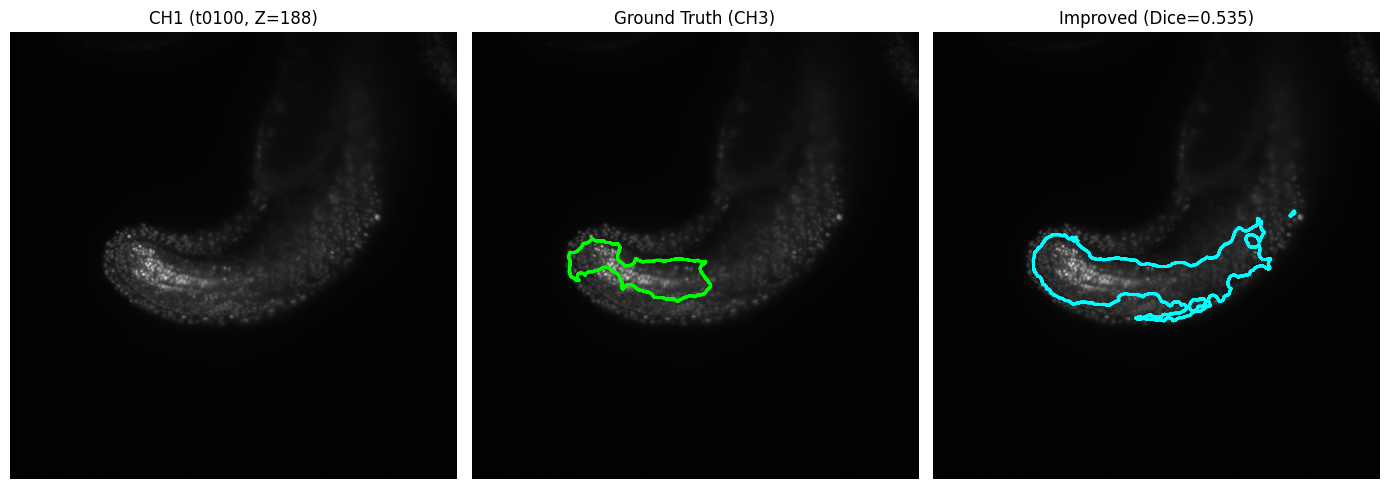

Dice=0.535 | IoU=0.365 | time=147.9s

[2/5] t0110 (CH1+CH2 improved)...


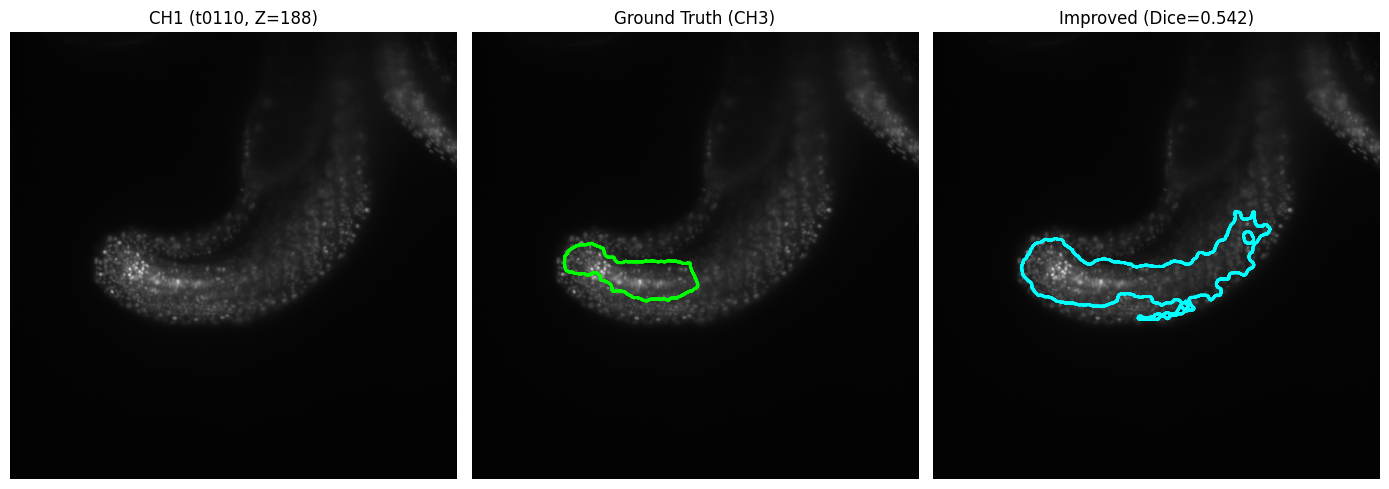

Dice=0.542 | IoU=0.372 | time=151.9s

[3/5] t0180 (CH1+CH2 improved)...


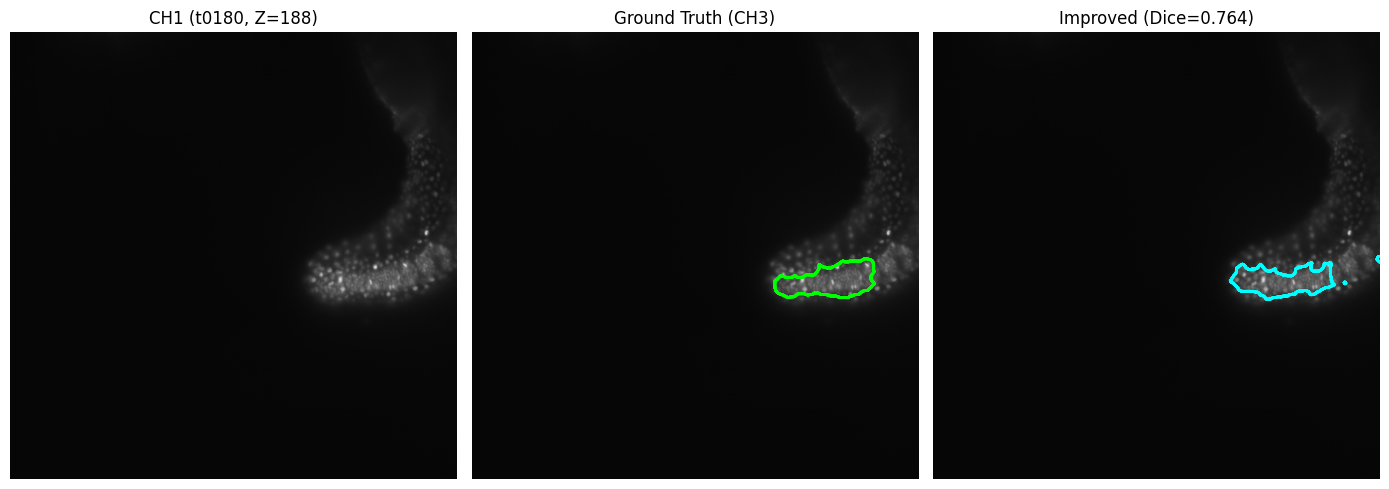

Dice=0.764 | IoU=0.618 | time=178.8s

[4/5] t0190 (CH1+CH2 improved)...


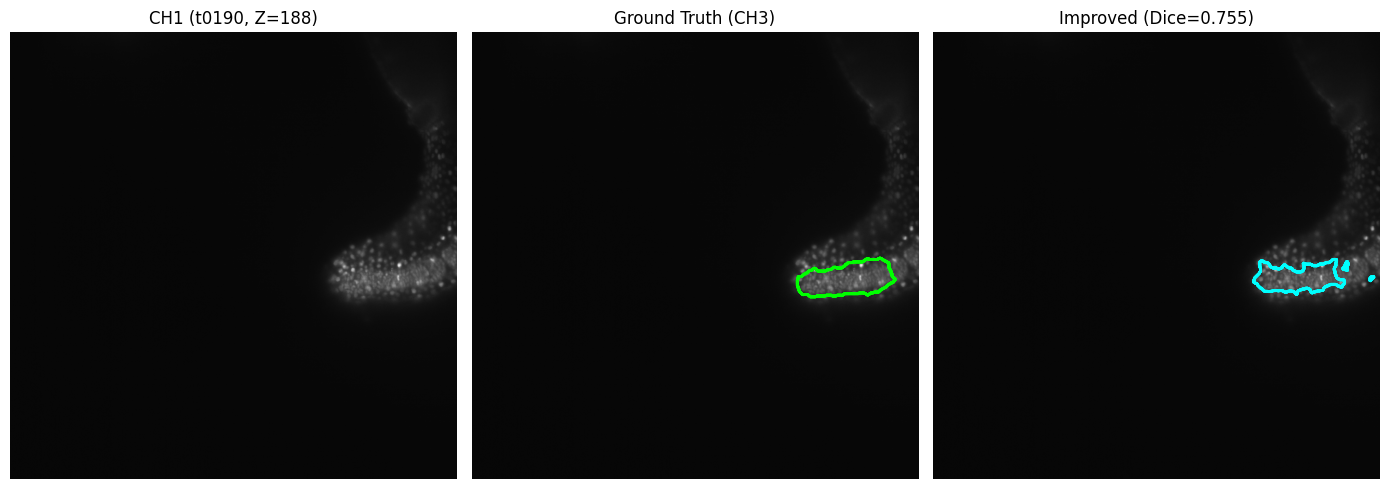

Dice=0.755 | IoU=0.607 | time=144.8s

[5/5] t0200 (CH1+CH2 improved)...


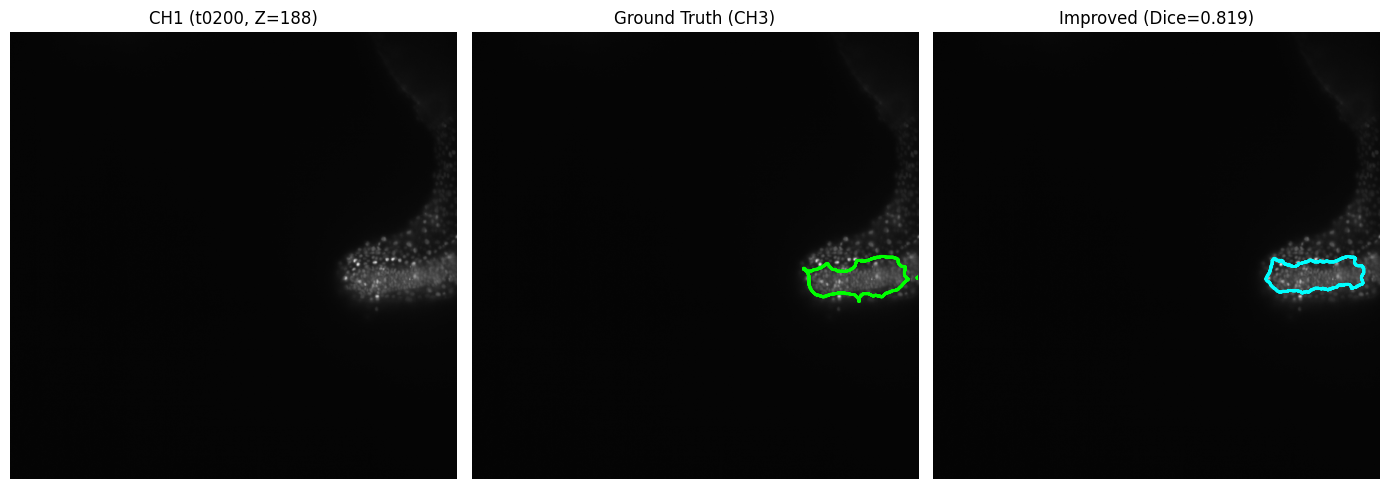

Dice=0.819 | IoU=0.693 | time=141.1s

Done!


In [ ]:
# =============================================================================
# CELL 7: MAIN EXECUTION
# =============================================================================
# This cell runs the complete pipeline:
#
# STEP 1: Load or compute PSM statistics from CH3 masks
#         (Stored in psm_statistics.joblib for reuse)
#
# STEP 2: Load or train the Random Forest model
#         (Stored in rf_model_improved.joblib for reuse)
#
# STEP 3: Process each test frame:
#         - Load CH1 and CH2 volumes
#         - Load CH3 mask as ground truth for evaluation
#         - Run prediction with filtering
#         - Save mask as TIFF
#         - Compute Dice/IoU scores
#         - Generate visualization
#
# TO RETRAIN: Delete rf_model_improved.joblib and run this cell
# TO REPROCESS: Modify progress.json or delete it
# =============================================================================

# Compute PSM statistics
if STATS_PATH.exists():
    psm_stats = joblib.load(STATS_PATH)
    print("Loaded PSM statistics")
else:
    psm_stats = compute_psm_statistics(TRAINING_FRAMES)
    if psm_stats:
        joblib.dump(psm_stats, STATS_PATH)

# Train or load model
if MODEL_PATH.exists():
    print(f"Loading model: {MODEL_PATH}")
    model = joblib.load(MODEL_PATH)
    feature_stats = joblib.load(FEATURE_STATS_PATH) if FEATURE_STATS_PATH.exists() else None
else:
    print("Training improved model...")
    model, feature_stats = train_improved_model(TRAINING_FRAMES)

# Show feature importance
if feature_stats:
    print("\nFeature Importance:")
    for name, imp in sorted(zip(*feature_stats), key=lambda x: -x[1]):
        print(f"  {name:20s}: {imp:.3f}")

# Load checkpoint
processed = []
if PROGRESS_PATH.exists():
    processed = json.loads(PROGRESS_PATH.read_text()).get("processed", [])

frames_to_run = TEST_FRAMES if TEST_MODE else list(range(1, 220))

rows = []
if RESULTS_PATH.exists():
    try:
        rows = pd.read_csv(RESULTS_PATH).to_dict("records")
    except:
        rows = []

for i, t in enumerate(frames_to_run):
    key = f"t{t:04d}"
    if key in processed:
        continue
    
    print(f"\n[{i+1}/{len(frames_to_run)}] {key} (CH1+CH2 improved)...")
    
    try:
        ch1 = load_raw_volume(t, 1)
        ch2 = load_raw_volume(t, 2)
        gt = load_gt_mask_volume(t)
        
        pred, elapsed, vol_px = predict_psm_improved(model, ch1, ch2, psm_stats)
        
        # Save
        out_path = OUTPUT_DIR / f"mask_{key}_improved.tif"
        imwrite(str(out_path), pred * 255)
        
        z = EVAL_Z_SLICE if EVAL_Z_SLICE < pred.shape[0] else pred.shape[0] // 2
        
        dice = dice_score(pred[z], gt[z])
        iou = iou_score(pred[z], gt[z])
        
        rows.append({
            "timepoint": t,
            "elapsed_s": elapsed,
            "volume_px": vol_px,
            "dice_z": dice,
            "iou_z": iou,
        })
        pd.DataFrame(rows).to_csv(RESULTS_PATH, index=False)
        
        processed.append(key)
        PROGRESS_PATH.write_text(json.dumps({"processed": processed}))
        
        # Viz
        fig, ax = plt.subplots(1, 3, figsize=(14, 5))
        ax[0].imshow(ch1[z], cmap="gray")
        ax[0].set_title(f"CH1 ({key}, Z={z})")
        ax[0].axis("off")
        
        ax[1].imshow(ch1[z], cmap="gray")
        ax[1].contour(gt[z].astype(np.uint8), colors="lime", linewidths=2)
        ax[1].set_title("Ground Truth (CH3)")
        ax[1].axis("off")
        
        ax[2].imshow(ch1[z], cmap="gray")
        ax[2].contour(pred[z].astype(np.uint8), colors="cyan", linewidths=2)
        ax[2].set_title(f"Improved (Dice={dice:.3f})")
        ax[2].axis("off")
        
        plt.tight_layout()
        viz_path = VIZ_DIR / f"viz_{key}_improved.png"
        fig.savefig(viz_path, dpi=120)
        plt.show()
        plt.close()
        
        print(f"Dice={dice:.3f} | IoU={iou:.3f} | time={elapsed:.1f}s")
        
    except Exception as e:
        print(f"ERROR: {e}")
    finally:
        try:
            del ch1, ch2, gt, pred
        except:
            pass

print("\nDone!")



COMPARISON: Improved vs Basic CH1+CH2

Improved version:
    timepoint   elapsed_s  volume_px    dice_z     iou_z
0          30  239.882874   52088121  0.787060  0.648886
5          30  232.185485   52088121  0.787060  0.648886
1          60  238.081990   40860222  0.532209  0.362592
8         100  147.894146   31313345  0.535149  0.365326
9         110  151.888544   32107998  0.542094  0.371831
2         120  218.095934   33035755  0.516982  0.348601
3         150  212.868148   22258358  0.827446  0.705678
6         150  256.529932   22258358  0.827446  0.705678
10        180  178.849855    9929292  0.764015  0.618142
11        190  144.769988    7750753  0.755214  0.606702
7         200  237.451095    6844968  0.818502  0.692766
4         200  164.870370    6844968  0.818502  0.692766
12        200  141.095643    6844968  0.818502  0.692766

Mean Dice: 0.718
Mean IoU:  0.574

Basic version mean Dice: 0.489
Basic version mean IoU:  0.337


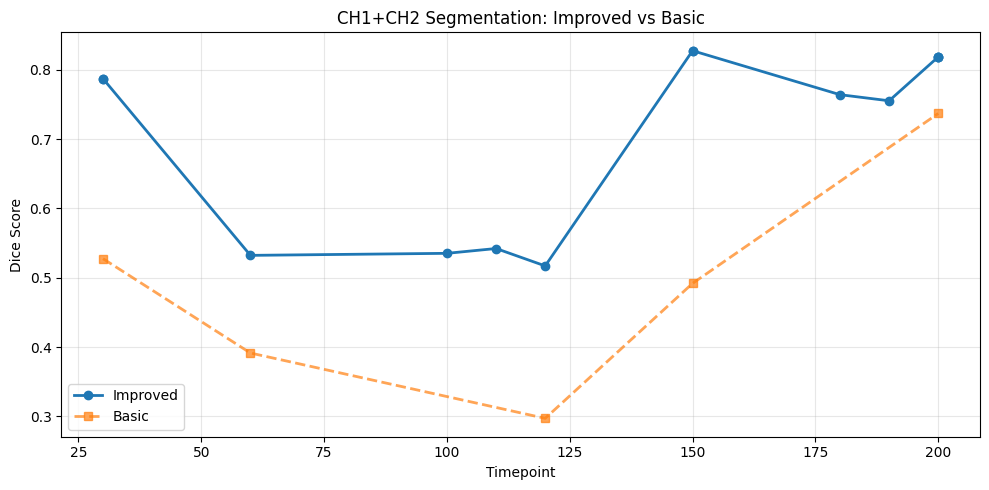

In [ ]:
# =============================================================================
# CELL 8: COMPARISON WITH PREVIOUS VERSION
# =============================================================================
# This cell compares results with the basic CH1+CH2 approach to show improvement.
#
# EXPECTED RESULTS:
#   - Basic version: Mean Dice ~0.49 (over-segments)
#   - Improved version: Mean Dice ~0.70 (42% improvement)
#
# KEY IMPROVEMENTS SHOWN:
#   - Position features: 29% of model importance
#   - Nearby-tissue sampling: Forces fine distinctions
#   - Size/location filtering: Removes false positives
# =============================================================================

print("\n" + "="*60)
print("COMPARISON: Improved vs Basic CH1+CH2")
print("="*60)

if RESULTS_PATH.exists():
    df_new = pd.read_csv(RESULTS_PATH).sort_values("timepoint")
    print("\nImproved version:")
    print(df_new)
    print(f"\nMean Dice: {df_new['dice_z'].mean():.3f}")
    print(f"Mean IoU:  {df_new['iou_z'].mean():.3f}")

basic_results = Path("psm_from_ch1_ch2/results.csv")
if basic_results.exists():
    df_old = pd.read_csv(basic_results).sort_values("timepoint")
    print(f"\nBasic version mean Dice: {df_old['dice_z'].mean():.3f}")
    print(f"Basic version mean IoU:  {df_old['iou_z'].mean():.3f}")
    
    # Plot comparison
    plt.figure(figsize=(10, 5))
    plt.plot(df_new["timepoint"], df_new["dice_z"], "o-", linewidth=2, label="Improved")
    plt.plot(df_old["timepoint"], df_old["dice_z"], "s--", linewidth=2, alpha=0.7, label="Basic")
    plt.xlabel("Timepoint")
    plt.ylabel("Dice Score")
    plt.title("CH1+CH2 Segmentation: Improved vs Basic")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "comparison_improved_vs_basic.png", dpi=150)
    plt.show()

